# Wonderful Wines of the World

## Timeline

Thursday: Finish most of the code; 

Friday: Combine best clusters; Agree on final clustering solution

Sat/Sun: Finish Paper Draft / Presentation Draft


## Paper

Business Understanding
- 1 paragraph about problem statement

Data Understanding
- No missing values
- Remove last row
- No duplicates
- Initial Histograms + Box plots

Data Prep
- Outliers
- RobustScaler Transform (Default position)

--- 1 page ---

Modelling (Value + Wine)

Clusters: 4-6

M: V / L: W
- Kmeans
- Hierarchical

F: V / B: W
- SOM
- Density Based (GMM, MS, DBSCAN)


Combined:
- Hierarchical

RFM??

Evaluation
- Summary of R2 scores
- Other Evaluation metric
- Cluster characterization - Mention RFM in relation to final clusters ?
- UMAP / TSNE viz to evaluate if points in the same clusters are near each other

--- 3 pages ---

Deployment
- Marketing strategy summary
- Add parallel plots 

--- end ---

## Presentation

- Intro: Describe problem and summary
- Wine Seg vs Value Seg
- Combi
- Which model/s and why
- Mostly evaluation 
- Marketing strategy
- Implications


## Initial Setup

In [1]:
## import libraries

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns

import os
from math import ceil



In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


In [3]:
from sklearn.base import clone

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, PowerTransformer, RobustScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, DBSCAN, estimate_bandwidth


from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE

from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

import graphviz


In [4]:
import warnings
warnings.filterwarnings('ignore')

# https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

# importing sompy enables more logging
logging.disable(logging.INFO)

In [5]:
## Note versions used

print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Scipy version ',sp.__version__)
print('Seaborn version ',sns.__version__)


Pandas version  1.3.3
Numpy version  1.21.2
Scipy version  1.7.1
Seaborn version  0.11.2


## Define some constant variables

In [6]:
#COLORS=['#d1d646', '#a7ca58', '#78bd6c', '#44af82', '#009c9f', '#4d8b8f', '#516c85', '#544b7b', '#59236f']
COLORS = ['#cc2a49', '#e06e60', '#f0a573', '#ffd884', '#ae9e95', '#5d7495', '#004494']
COLORS = ['#7a2b5d', '#975c86', '#b38dad', '#d0bed6', '#edf0ff', '#eae1cd', '#e8d19a', '#e6c064', '#e3ae29']

CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = COLORS.copy() #['#9faf1f', '#aac55d', '#b5da99', '#d7ebcb', '#fafafa', '#dbc5d5', '#cb9ebf', '#bb77a8', '#ae4c8c']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)

sns.set_palette(DEFAULT_PALETTE)
DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = False


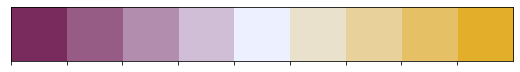

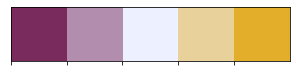

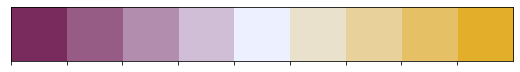

In [7]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
plt.show()

In [8]:
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 70

In [9]:
show_plots = True
save_plots = False
img_counter = 0
random_state = 0

## Define some functions

In [10]:
def save_fig(title, fig, dest='img/'):
    if save_plots == True:
        fn = dest + '_' + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight')
        


In [11]:
## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Numeric Variables' Histograms"):
    fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), \
                             constrained_layout=True)
        
    for ax, feat in zip(axes.flatten(), features):
        ax.hist(df[feat], color=COLORS[0])
        ax.set_title(feat, y=1)
    
    if (len(axes.flatten())) > len(features):
        for f in range(len(axes.flatten())-len(features)):
            axes.flatten()[(f+1)*-1].axis('off')
    plt.suptitle(title)
    save_fig(title, fig)

    plt.show()

In [12]:
## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if SHOW_PLOTS:
        fig = plt.figure(figsize=(5*rows,4*rows),
                         constrained_layout=True)
        
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(2, 1, sharex=True, \
                                gridspec_kw={'height_ratios': [4,1]})
        
            axs[0].hist(df[feat], color=COLORS[0])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1, fontsize=6*rows)
        
            axs[1].set_xlabel(None)
            flierprops = dict(markerfacecolor='None', markersize=6,  markeredgecolor=COLORS[0])
            sns.boxplot(x=df[feat], ax=axs[1], color=COLORS[0], flierprops=flierprops)
            axs[1].set_xlabel(None)

            subf.suptitle(None)
        
        plt.suptitle(title, fontsize=8*rows)
        if SAVE_PLOTS:
            save_fig(title, fig)
        
        plt.show()
    else:
        print("show_plots is currently set to False")

In [13]:
def getIQR(df, colname) :
    q25 = df[colname].quantile(.25)
    q75 = df[colname].quantile(.75)
    iqr = (q75 - q25)

    upper_lim = q75 + 2 * iqr
    lower_lim = q25 - 2 * iqr

    above_ul = df.loc[df[colname]>upper_lim]
    below_ll = df.loc[df[colname]<lower_lim]
    
    if len(above_ul) > 0 :
        print(str(len(above_ul)) + " or " + str(round((100*len(above_ul)/len(df)),4)) + "% of rows are above the UL ["+ colname + "].")
    if len(below_ll) > 0 :
        print(str(len(below_ll)) + " or " + str(round((100*len(below_ll)/len(df)),4)) + "% of rows are below the LL ["+ colname + "].")

    
    return upper_lim, lower_lim, len(above_ul), len(below_ll)




## Load Dataset

In [14]:
df = pd.read_excel('../data/WonderfulWinesoftheWorld.xlsx')
df_original = df.copy(deep=True)

## Remove last row
df.drop(df.tail(1).index,inplace=True)

##
df['Custid'] = df['Custid'].astype(int) 

df.set_index('Custid', inplace=True)

df.head(3)

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
Custid,,,,,,,,,,,,,,,,,
5325,653.0,55.0,20.0,78473.0,20.0,18.0,826.0,445.0,7.0,67.0,4.0,26.0,2.0,1.0,1.0,36.0,5.0
3956,1041.0,75.0,18.0,105087.0,36.0,33.0,1852.0,539.0,2.0,49.0,0.0,46.0,1.0,3.0,0.0,20.0,4.0
3681,666.0,18.0,12.0,27984.0,4.0,56.0,39.0,-7.0,88.0,4.0,29.0,14.0,32.0,21.0,48.0,60.0,8.0


In [15]:
df.shape

(10000, 17)

In [16]:
df.isna().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

## Data Understanding

### Check datatypes

In [17]:
df.dtypes

Dayswus        float64
Age            float64
Edu            float64
Income         float64
Freq           float64
Recency        float64
Monetary       float64
LTV            float64
Perdeal        float64
Dryred         float64
Sweetred       float64
Drywh          float64
Sweetwh        float64
Dessert        float64
Exotic         float64
WebPurchase    float64
WebVisit       float64
dtype: object

All variables are numeric.

### Check for duplicates

In [18]:
print(df[df.duplicated(keep=False)])

Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []


### Identify features for segmentation

In [19]:
## Wine preference features
wine_features = ['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']

## Value segmentation features
value_features = ['Dayswus', 'Freq', 'Recency', 'Monetary', 'LTV', 'Perdeal']

## Separate Demographic features for cluster descriptions later
demog_features = ['Age', 'Edu', 'Income']

## Separate other features
other_features = ['WebPurchase', 'WebVisit']


### Distributions of values for variables

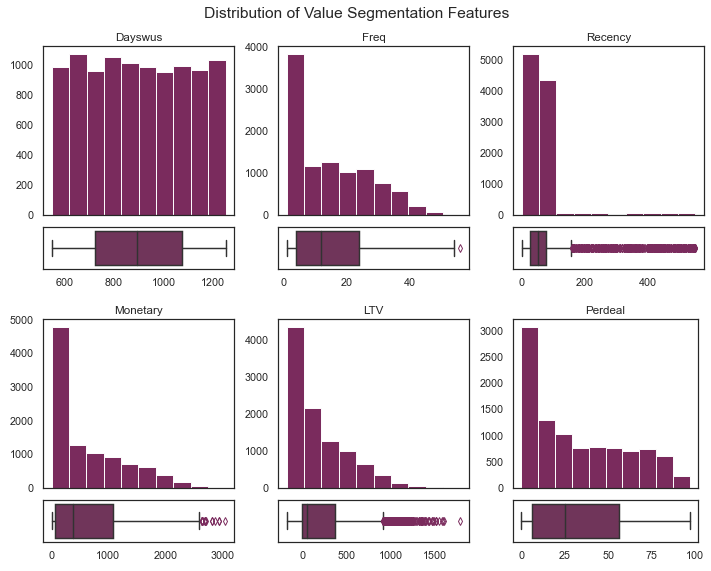

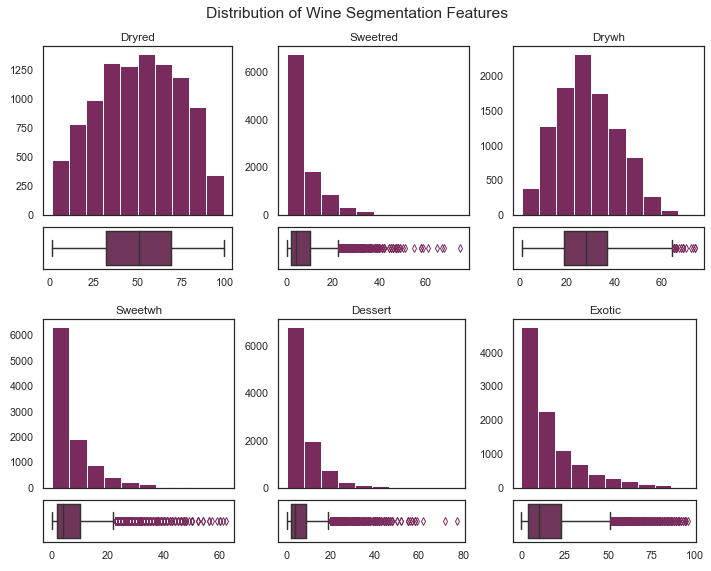

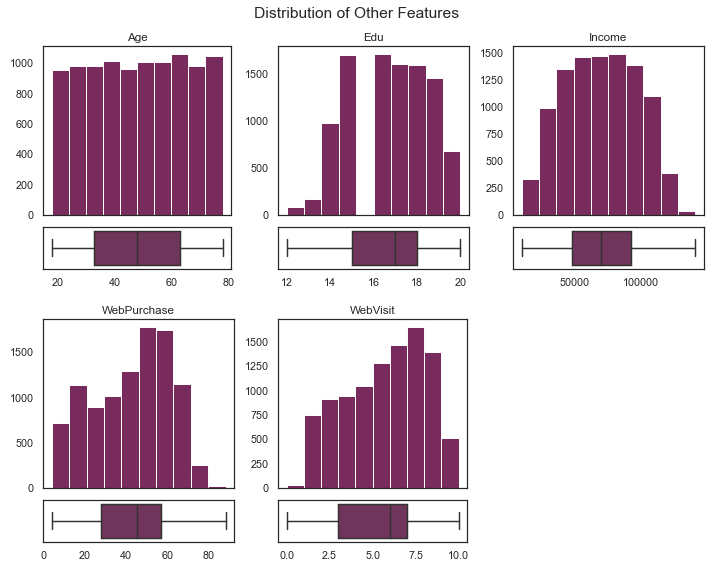

In [20]:
plot_histograms_boxplots(df, value_features, rows=2, title='Distribution of Value Segmentation Features')
plot_histograms_boxplots(df, wine_features, rows=2, title='Distribution of Wine Segmentation Features')
plot_histograms_boxplots(df, (demog_features+other_features), rows=2, title='Distribution of Other Features')

## Data Preparation

### Check for correlation

In [21]:
def make_corr_heatmap(df, method, title="Triangle Correlation Heatmap"):
    l = len(df.columns.tolist())
    fig = plt.figure(figsize=(2*l, 1.5*l))
    mask = np.triu(np.ones_like(df.corr(method=method), dtype=bool))
    heatmap = sns.heatmap(df.corr(method=method), mask=mask, vmin=-1, vmax=1, annot=True, fmt='.2f' ,cmap=DIV_CMAP)
    heatmap.set_title(title, fontdict={'fontsize':18}, pad=2);
    save_fig(title, fig)
    plt.show()

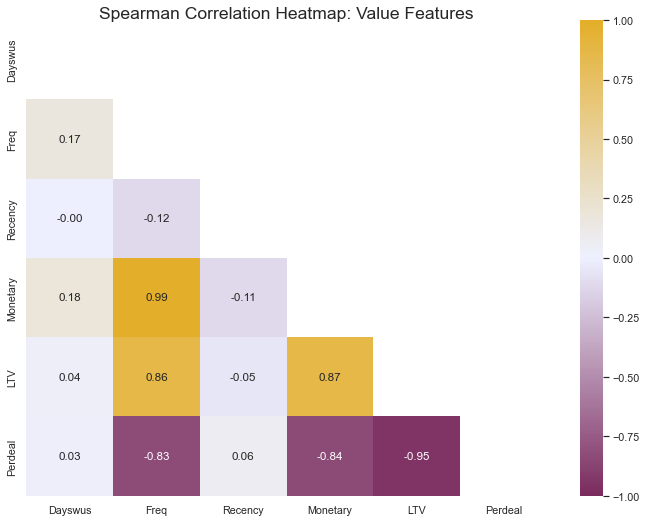

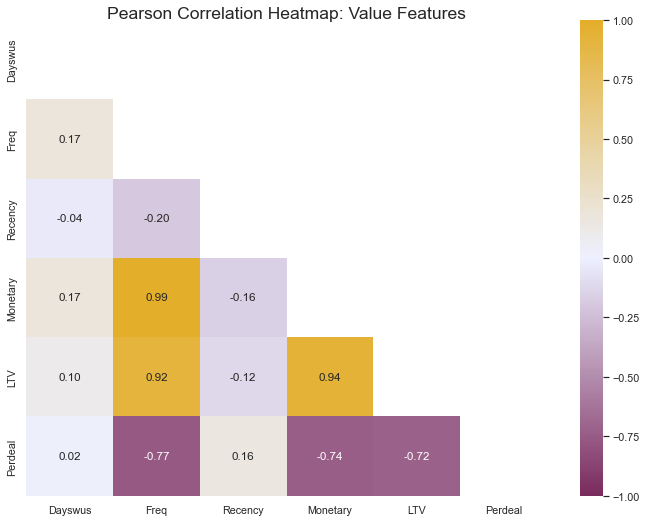

In [22]:
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap: Value Features")
make_corr_heatmap(df[value_features], 'pearson', title="Pearson Correlation Heatmap: Value Features")


In [23]:
## Remove Perdeal because highly correlated with multiple feats
value_features.remove('Perdeal')

## Remove Monetary because highly correlated with Freq, LTV
value_features.remove('Monetary')


## Remove Frequency and LTV because highly correlated with Monetary
value_features2 = ['Dayswus', 'Recency', 'Monetary']

value_features

['Dayswus', 'Freq', 'Recency', 'LTV']

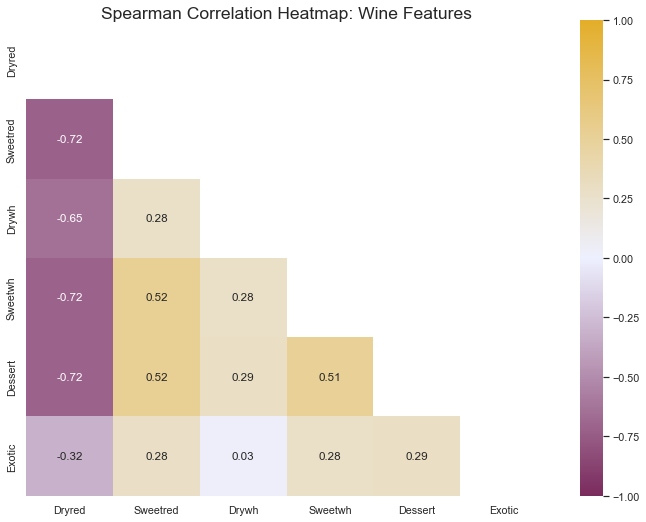

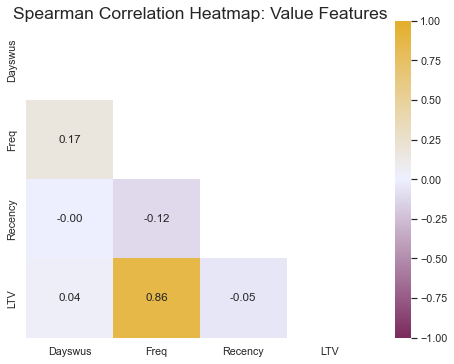

In [24]:
make_corr_heatmap(df[wine_features], 'spearman', title="Spearman Correlation Heatmap: Wine Features")
make_corr_heatmap(df[value_features], 'spearman', title="Spearman Correlation Heatmap: Value Features")


### Check for outliers

In [25]:
for v in df.columns.tolist():
    getIQR(df, v)

363 or 3.63% of rows are above the UL [Recency].
117 or 1.17% of rows are above the UL [LTV].
358 or 3.58% of rows are above the UL [Sweetred].
2 or 0.02% of rows are above the UL [Drywh].
365 or 3.65% of rows are above the UL [Sweetwh].
474 or 4.74% of rows are above the UL [Dessert].
331 or 3.31% of rows are above the UL [Exotic].


Too many outliers to remove just based on IQR

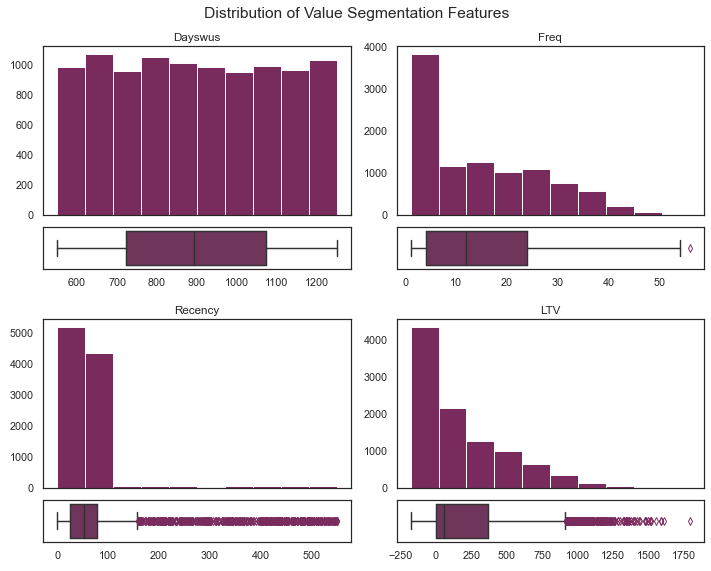

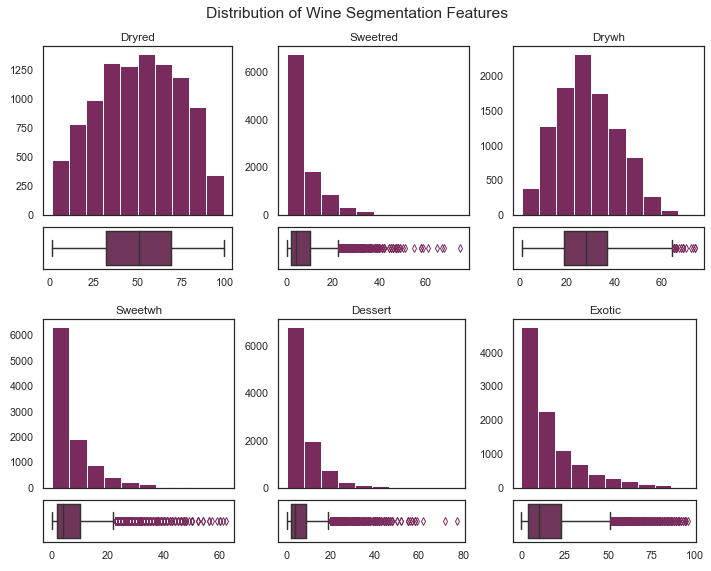

In [26]:
plot_histograms_boxplots(df, value_features, rows=2, title='Distribution of Value Segmentation Features')
plot_histograms_boxplots(df, wine_features, rows=2, title='Distribution of Wine Segmentation Features')

In [27]:
df['Outlier'] = 0

In [28]:
df.loc[df['Dessert']>70,['Outlier']] = 1
df.loc[df['Sweetred']>70,['Outlier']] = 1

In [29]:
df.loc[df['Freq']>55,['Outlier']] = 1
df.loc[df['LTV']>1750,['Outlier']] = 1

In [30]:
df_outliers = df.copy()

In [31]:
df = df[df['Outlier']==0]

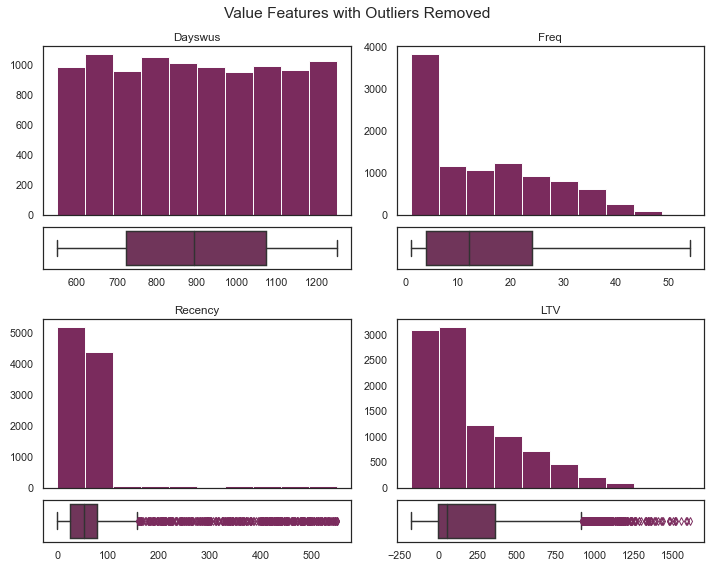

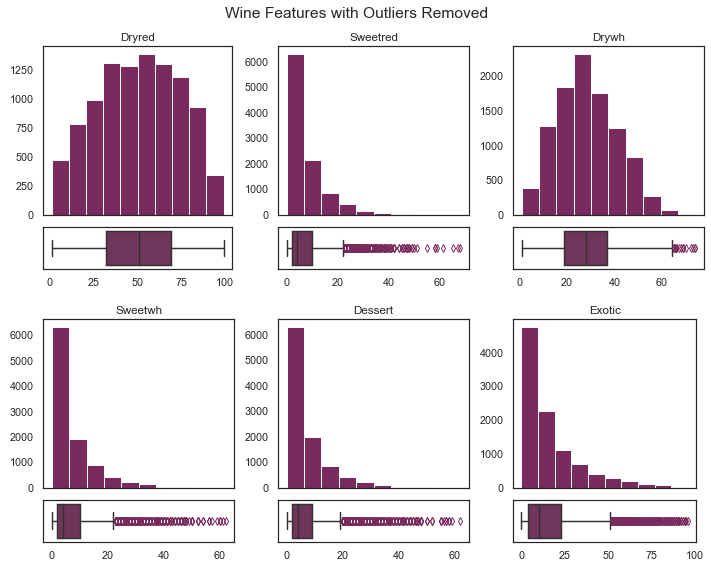

In [32]:
plot_histograms_boxplots(df, value_features, rows=2, title='Value Features with Outliers Removed')
plot_histograms_boxplots(df, wine_features, rows=2, title='Wine Features with Outliers Removed')



## Transform Variables

### MinMax Scaler

We only scale the Value Segmentation Features because the Wine Segmentation Features are all in the same scale (percentage) already.

In [33]:
mmscaler = MinMaxScaler()

value_feats_mm = value_features.copy()

for fi in range(len(value_feats_mm)):
    t = value_feats_mm[fi] + '_mm'
    value_feats_mm[fi] = t
    df[t] = df[value_features[fi]]

df[value_feats_mm] = mmscaler.fit_transform(df[value_feats_mm])


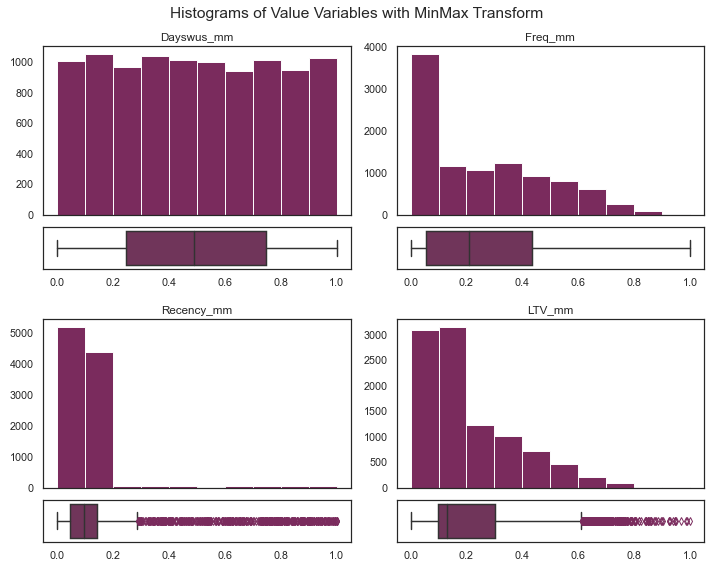

In [34]:
plot_histograms_boxplots(df, value_feats_mm, rows=2, title='Histograms of Value Variables with MinMax Transform')


### Transform wine features to decimal (from percentage)

In [35]:
wine_feats_dec = wine_features.copy()

for fi in range(len(wine_feats_dec)):
    t = wine_feats_dec[fi] + '_dec'
    wine_feats_dec[fi] = t
    df[t] = df[wine_features[fi]]/100


## Use DBSCAN to identify 'noise' rows

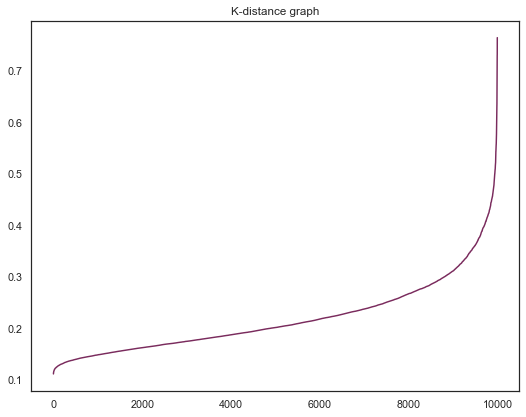

In [36]:
## DBSCAN

# K-distance graph to find out the right eps value
vars_ = wine_feats_dec + value_feats_mm
neigh = NearestNeighbors(n_neighbors=50)
neigh.fit(df[vars_])
distances, _ = neigh.kneighbors(df[vars_])
distances = np.sort(distances[:, -1])

fig, axis = plt.subplots(figsize=(9,7))
plt.plot(distances, color=COLORS[0])
plt.title('K-distance graph')
plt.show()


In [37]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=.35, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[vars_])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [38]:
# Concatenating the labels to df
df_dbscan = pd.concat([df[vars_], pd.Series(dbscan_labels, index=df.index, name="dbscan_labels")], axis=1)
df_dbscan.groupby(['dbscan_labels']).count()

,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm
dbscan_labels,,,,,,,,,,
-1,30,30,30,30,30,30,30,30,30,30
0,9966,9966,9966,9966,9966,9966,9966,9966,9966,9966


In [39]:
df_nonoise = df_dbscan.loc[df_dbscan['dbscan_labels'] != -1]

In [40]:
print('Percentage of rows considered noise:')
100*len(df_dbscan.loc[df_dbscan['dbscan_labels'] == -1])/len(df)

Percentage of rows considered noise:


0.30012004801920766

## Summary of Variables

In [41]:
## Original value features
print(value_features)
df[value_features].head(3)

['Dayswus', 'Freq', 'Recency', 'LTV']


,Dayswus,Freq,Recency,LTV
Custid,,,,
5325,653.0,20.0,18.0,445.0
3956,1041.0,36.0,33.0,539.0
3681,666.0,4.0,56.0,-7.0


In [42]:
## Original wine features
print(wine_features)
df[wine_features].head(3)

['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert', 'Exotic']


,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
Custid,,,,,,
5325,67.0,4.0,26.0,2.0,1.0,1.0
3956,49.0,0.0,46.0,1.0,3.0,0.0
3681,4.0,29.0,14.0,32.0,21.0,48.0


In [43]:
## MinMax transformed value features
print(value_feats_mm)
df[value_feats_mm].head(3)

['Dayswus_mm', 'Freq_mm', 'Recency_mm', 'LTV_mm']


,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm
Custid,,,,
5325,0.147143,0.358491,0.032787,0.348824
3956,0.701429,0.660377,0.060109,0.401456
3681,0.165714,0.056604,0.102004,0.095745


In [44]:
## Decimal wine features
print(wine_feats_dec)
df[wine_feats_dec].head(3)

['Dryred_dec', 'Sweetred_dec', 'Drywh_dec', 'Sweetwh_dec', 'Dessert_dec', 'Exotic_dec']


,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec
Custid,,,,,,
5325,0.67,0.04,0.26,0.02,0.01,0.01
3956,0.49,0.00,0.46,0.01,0.03,0.00
3681,0.04,0.29,0.14,0.32,0.21,0.48


## Clustering

In [45]:
# Heirarchical and Agglomerative Clustering of customers based on Value and Engagement
df_vf = df[value_feats_mm]

In [46]:
df_vf.head()

,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm
Custid,,,,
5325,0.147143,0.358491,0.032787,0.348824
3956,0.701429,0.660377,0.060109,0.401456
3681,0.165714,0.056604,0.102004,0.095745
2829,0.712857,0.018868,0.083789,0.096305
8788,0.410000,0.018868,0.005464,0.101904


In [47]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

In [48]:
def elbow_curve(df, max_clusters=10):
    inertia = []
    range_clusters = np.arange(1, max_clusters)
    for n_clus in range_clusters:  # iterate over desired ncluster range
        kmclust = KMeans(n_clusters=n_clus, n_init=15, random_state=42)
        kmclust.fit(df)
        inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution
    
    # The inertia plot
    plt.figure(figsize=(9,5))
    plt.plot(range_clusters, inertia)
    plt.ylabel("Inertia: SSw")
    plt.xlabel("Number of clusters")
    plt.title("Inertia plot over clusters", size=15)
    plt.show()

In [49]:
def clust_r2(df, kmeans, hclust, title='Continuous'):

    # Obtaining the R² scores for each cluster solution on continuous variables
    r2_scores = {}
    r2_scores['kmeans'] = get_r2_scores(df, kmeans)

    for linkage in ['complete', 'average', 'single', 'ward']:
        r2_scores[linkage] = get_r2_scores(
            df, hclust.set_params(linkage=linkage)
        )

    pd.DataFrame(r2_scores)

    # Visualizing the R² scores for each cluster solution on value/engagement variables
    pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

    plt.title(f"{title} Variables:\nR² plot for various clustering methods\n", fontsize=21)
    plt.legend(title="Cluster methods", title_fontsize=11)
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R² metric", fontsize=13)
    plt.show()

In [50]:
def hclust_dendogram(df, hclust, threshold=100, linkage='ward', distance='euclidean'):
    
    hclust.fit_predict(df)
    
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

    # create the counts of samples under each node (number of points being merged)
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    # hclust.children_ contains the observation ids that are being merged together
    # At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
    for i, merge in enumerate(hclust.children_):
        # track the number of observations in the current cluster being formed
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                # If this is True, then we are merging an observation
                current_count += 1  # leaf node
            else:
                # Otherwise, we are merging a previously formed cluster
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
    # the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
    # the counts indicate the number of points being merged (dendrogram's x-axis)
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sns.set()
    fig = plt.figure(figsize=(11,5))
    # The Dendrogram parameters need to be tuned
    y_threshold = threshold
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{distance.title()} Distance', fontsize=13)
    plt.show()

In [51]:
def kmeans_silhouette(df, kmeans, max_clusters=10):
    # Adapted from:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

    # Storing average silhouette metric
    avg_silhouette = []
    range_clusters = np.arange(1, max_clusters + 1)
    
    for nclus in range_clusters:
        # Skip nclus == 1
        if nclus == 1:
            continue

        # Create a figure
        fig = plt.figure(figsize=(13, 7))

        # Initialize the KMeans object with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmeans = KMeans(n_clusters = nclus, n_init=15, random_state=42)
        cluster_labels = kmeans.fit_predict(df)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df, cluster_labels)
        avg_silhouette.append(silhouette_avg)
        print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df, cluster_labels)

        y_lower = 10
        for i in range(nclus):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            # Get y_upper to demarcate silhouette y range size
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            # Filling the silhouette
            color = cm.nipy_spectral(float(i) / nclus)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        plt.title("The silhouette plot for the various clusters.")
        plt.xlabel("The silhouette coefficient values")
        plt.ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")

        # The silhouette coefficient can range from -1, 1
        xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
        plt.xlim([xmin, xmax])

        # The (nclus+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        plt.ylim([0, len(df) + (nclus + 1) * 10])

        plt.yticks([])  # Clear the yaxis labels / ticks
        plt.xticks(np.arange(xmin, xmax, 0.1))

In [52]:
kmeans = KMeans(n_init=15, random_state=42)

hclust = AgglomerativeClustering(compute_distances=True)

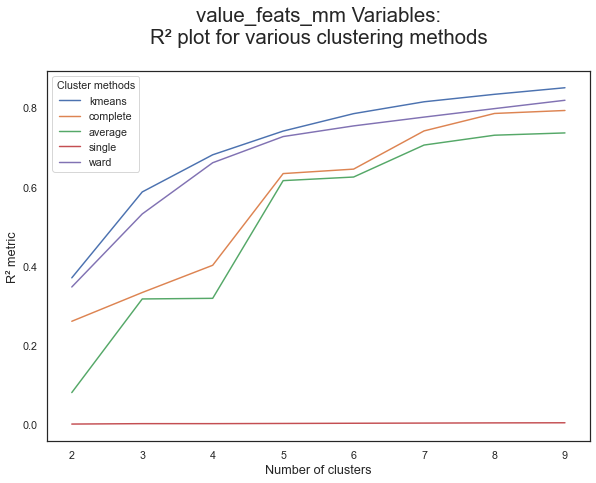

In [53]:
clust_r2(df_vf, kmeans, hclust, 'value_feats_mm')

For n_clusters = 2, the average silhouette_score is : 0.3547463090373327
For n_clusters = 3, the average silhouette_score is : 0.38430288343341235
For n_clusters = 4, the average silhouette_score is : 0.3854589870050684
For n_clusters = 5, the average silhouette_score is : 0.40711948118969954
For n_clusters = 6, the average silhouette_score is : 0.3628455028427132
For n_clusters = 7, the average silhouette_score is : 0.35740519890700556
For n_clusters = 8, the average silhouette_score is : 0.3521759928956415
For n_clusters = 9, the average silhouette_score is : 0.3489450109357692
For n_clusters = 10, the average silhouette_score is : 0.3263244360687686


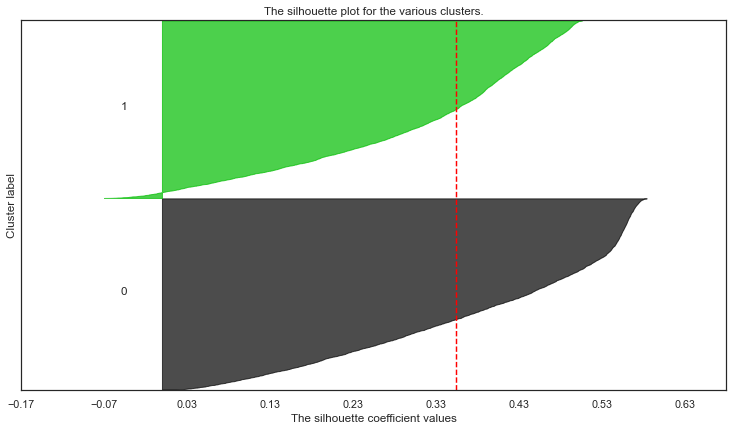

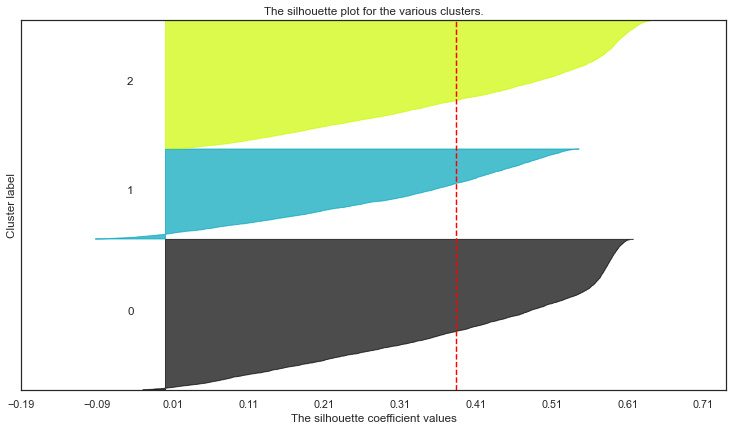

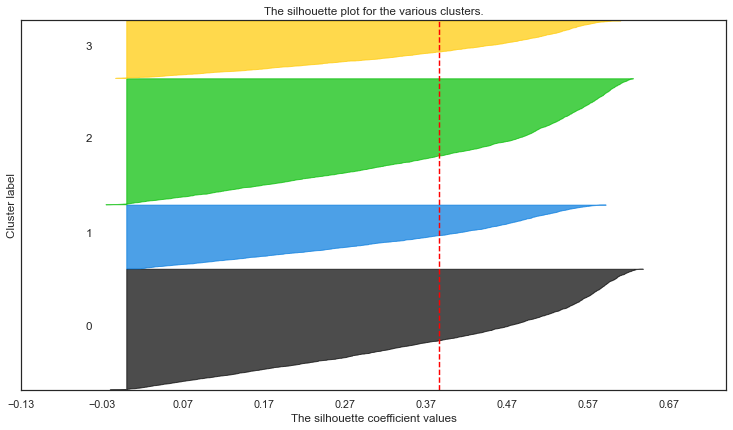

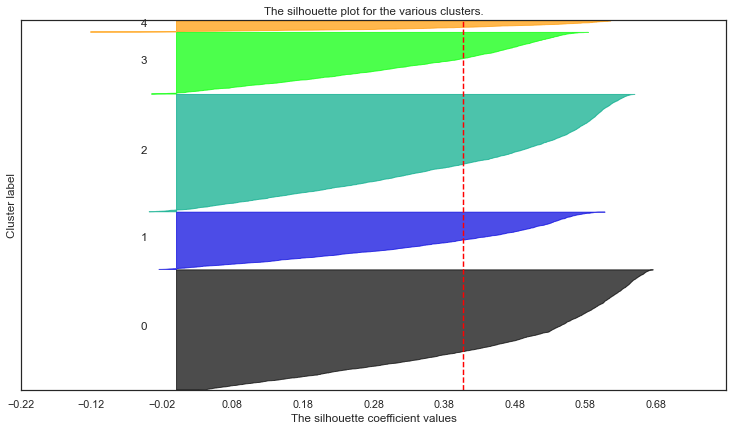

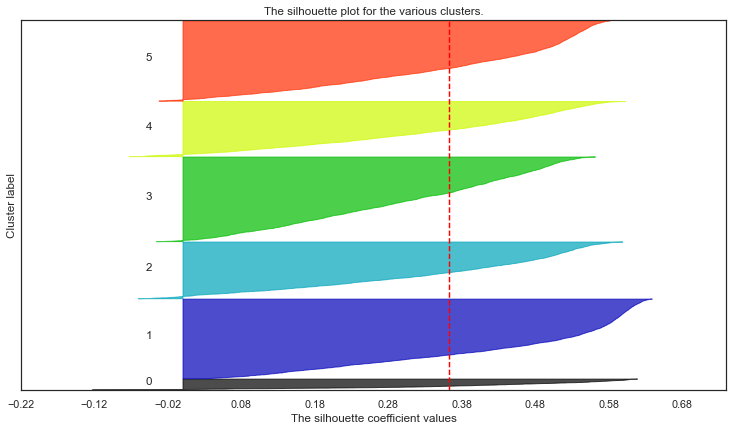

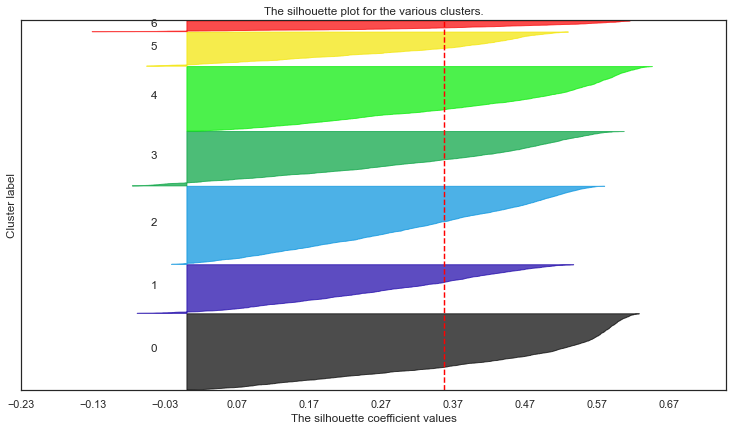

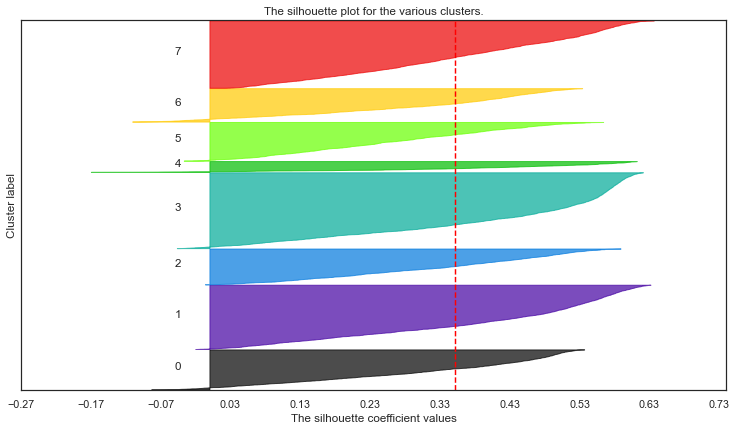

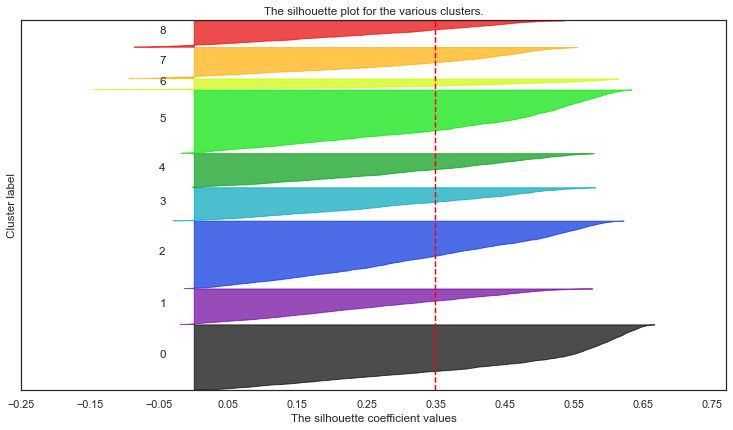

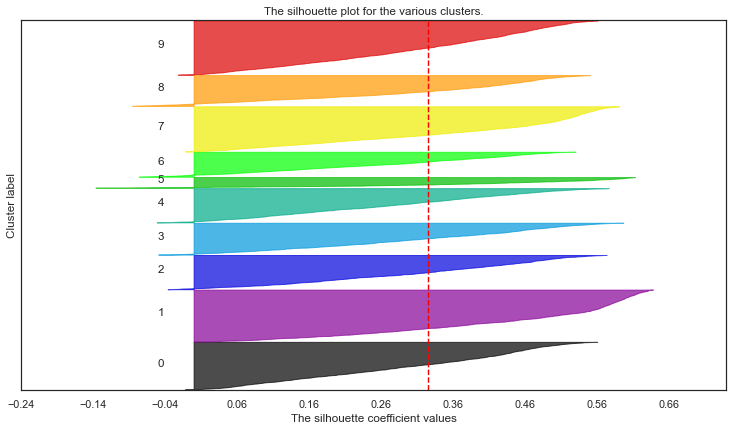

In [54]:
kmeans_silhouette(df_vf, kmeans)

In [55]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
km_vf_labels = kmclust.fit_predict(df_vf)
km_vf_labels

array([1, 3, 2, ..., 2, 0, 3])

In [56]:
# Characterizing the final clusters
df_vf_concat = pd.concat((df, pd.Series(km_vf_labels, name='labels')), axis=1)
df_vf_concat.groupby('labels').mean()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,...,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec
labels,,,,,,,,,,,,,,,,,,,,,
0.0,894.076897,48.090167,16.774413,70340.013610,14.682545,62.305206,624.734263,209.967676,32.212317,50.793807,...,0.491538,0.258161,0.113489,0.217227,0.507938,0.069973,0.284321,0.069575,0.068020,0.163229
1.0,900.663492,48.224127,16.775238,69762.833016,14.790476,64.406984,630.778413,211.982857,32.098413,49.879365,...,0.500948,0.260198,0.117317,0.218355,0.498794,0.071289,0.289473,0.068521,0.071575,0.164959
2.0,900.930664,47.914388,16.699870,69961.275065,14.644531,61.514648,623.841471,209.285482,32.564779,50.339844,...,0.501330,0.257444,0.112049,0.216845,0.503398,0.070931,0.284229,0.070550,0.070524,0.165999
3.0,898.241993,47.566548,16.759431,69198.803559,14.345196,61.631317,607.450534,204.743060,32.485409,50.720285,...,0.497489,0.251796,0.112261,0.214302,0.507203,0.068875,0.283295,0.072783,0.067687,0.163210


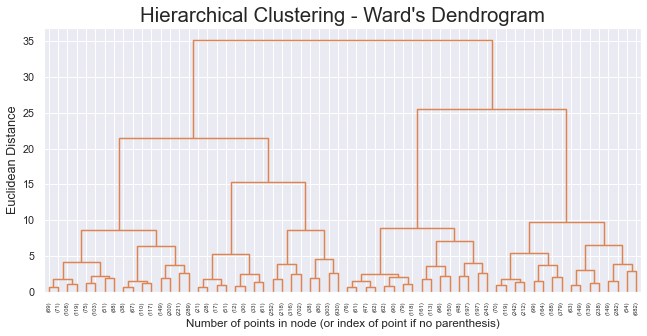

In [57]:
hclust_dendogram(df_vf, hclust, threshold=55, linkage='ward', distance='euclidean')

In [58]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=4)
hc_vf_labels = hclust.fit_predict(df_vf)
hc_vf_labels

array([3, 2, 0, ..., 0, 0, 2], dtype=int64)

In [59]:
# Characterizing the clusters
df_vf_concat = pd.concat((df, pd.Series(hc_vf_labels, name='labels')), axis=1)
df_vf_concat.groupby('labels').mean()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,...,Dayswus_mm,Freq_mm,Recency_mm,LTV_mm,Dryred_dec,Sweetred_dec,Drywh_dec,Sweetwh_dec,Dessert_dec,Exotic_dec
labels,,,,,,,,,,,,,,,,,,,,,
0.0,903.014388,47.717626,16.708993,69640.368705,14.473741,60.994245,614.385612,205.878058,32.872302,50.364029,...,0.504306,0.254222,0.111101,0.214937,0.503640,0.070302,0.284295,0.071050,0.070353,0.168345
1.0,891.859516,48.179239,16.779931,70417.269896,14.706574,61.718339,626.251903,211.184083,32.069896,50.828028,...,0.488371,0.258615,0.112420,0.217908,0.508280,0.070550,0.283862,0.069152,0.067896,0.160249
2.0,900.129390,47.693777,16.746149,69552.951941,14.523722,62.911892,616.164510,206.518792,32.226741,50.436229,...,0.500185,0.255165,0.114594,0.215296,0.504362,0.068805,0.285471,0.072822,0.068349,0.164849
3.0,899.388693,48.300353,16.752650,69941.426384,14.887515,64.832155,636.975265,214.201413,32.118375,50.050648,...,0.499127,0.262029,0.118091,0.219598,0.500506,0.071614,0.287809,0.068216,0.071649,0.164976
